# Przetwarzanie danych

## Importy

In [53]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from ydata_profiling import ProfileReport

In [54]:
matches = pd.read_csv('bigger_matches.csv', index_col=0)

## EDA (Eksploracyjna analiza danych)

In [55]:
matches.shape

(3800, 27)

In [56]:
matches.dtypes

date             object
time             object
comp             object
round            object
day              object
venue            object
result           object
gf                int64
ga                int64
opponent         object
xg              float64
xga             float64
poss            float64
attendance      float64
captain          object
formation        object
referee          object
match report     object
notes           float64
sh              float64
sot             float64
dist            float64
fk              float64
pk                int64
pkatt             int64
season            int64
team             object
dtype: object

### Zamiana poszczególnych kolumn na odpowiednie typy

In [57]:
matches["date"] = pd.to_datetime(matches["date"])
matches["venue_code"] = matches["venue"].astype("category").cat.codes
matches["opponent_code"] = matches["opponent"].astype("category").cat.codes
matches["referee_code"] = matches["referee"].astype("category").cat.codes
matches["hour"] = matches["time"].str.replace(":.+", "", regex=True).astype("int")
matches["day_code"] = matches["date"].dt.dayofweek
matches["target"] = (matches["result"] == "W").astype(int)
matches.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,pk,pkatt,season,team,venue_code,opponent_code,referee_code,hour,day_code,target
1,2023-08-11,20:00,Premier League,Matchweek 1,Fri,Away,W,3,0,Burnley,...,0,0,2023,Manchester City,0,5,4,20,4,1
3,2023-08-19,20:00,Premier League,Matchweek 2,Sat,Home,W,1,0,Newcastle Utd,...,0,0,2023,Manchester City,1,16,25,20,5,1
4,2023-08-27,14:00,Premier League,Matchweek 3,Sun,Away,W,2,1,Sheffield Utd,...,0,1,2023,Manchester City,0,19,9,14,6,1
5,2023-09-02,15:00,Premier League,Matchweek 4,Sat,Home,W,5,1,Fulham,...,1,1,2023,Manchester City,1,9,18,15,5,1
6,2023-09-16,15:00,Premier League,Matchweek 5,Sat,Away,W,3,1,West Ham,...,0,0,2023,Manchester City,0,24,1,15,5,1


### Odrzucenie niepotrzebnych kolumn

In [58]:
matches.drop(columns=["venue", "time", "comp", "round", "day", "venue","result", "captain", "referee", "match report", "notes", "opponent", "formation", "attendance"], inplace=True)

In [59]:
matches.head()

,date,gf,ga,xg,xga,poss,sh,sot,dist,fk,pk,pkatt,season,team,venue_code,opponent_code,referee_code,hour,day_code,target
1,2023-08-11,3,0,1.9,0.3,65.0,17.0,8.0,13.9,0.0,0,0,2023,Manchester City,0,5,4,20,4,1
3,2023-08-19,1,0,1.0,0.3,59.0,14.0,4.0,17.9,0.0,0,0,2023,Manchester City,1,16,25,20,5,1
4,2023-08-27,2,1,3.5,0.7,79.0,29.0,9.0,17.3,2.0,0,1,2023,Manchester City,0,19,9,14,6,1
5,2023-09-02,5,1,2.2,1.4,68.0,6.0,4.0,14.8,0.0,1,1,2023,Manchester City,1,9,18,15,5,1
6,2023-09-16,3,1,3.6,0.9,68.0,29.0,13.0,16.4,1.0,0,0,2023,Manchester City,0,24,1,15,5,1


### Mapa korelacji dla ramki matches

<Axes: >

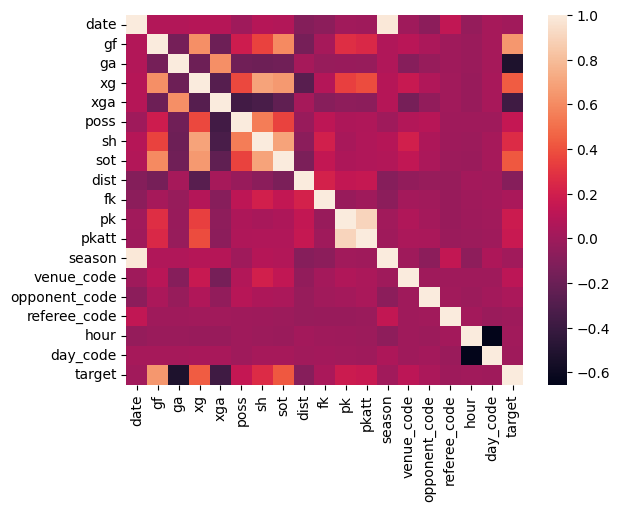

In [60]:
sns.heatmap(matches.drop(columns="team").corr())

### Wpływ współczynnika oczekiwanych goli na rezultat meczu

<Axes: xlabel='target', ylabel='count'>

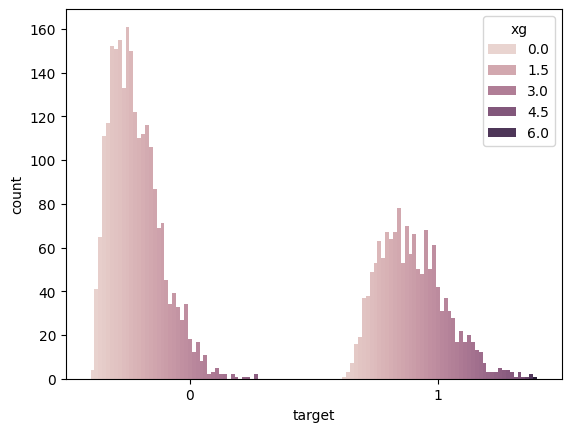

In [61]:
sns.countplot(x="target", hue="xg", data=matches)

### Utworzenie ProfileReportu, dla ułatwienia analizy danych

In [62]:
# ProfileReport(matches, title="Profiling report for matches")

In [63]:
matches.dtypes

date             datetime64[ns]
gf                        int64
ga                        int64
xg                      float64
xga                     float64
poss                    float64
sh                      float64
sot                     float64
dist                    float64
fk                      float64
pk                        int64
pkatt                     int64
season                    int64
team                     object
venue_code                 int8
opponent_code              int8
referee_code               int8
hour                      int32
day_code                  int32
target                    int32
dtype: object

### Tworzenie średniej kroczącej

In [64]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("date")
    rolling_stats = group[cols].rolling(3, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

In [65]:
cols = ["gf", "ga", "sh", "sot", "dist", "fk", "pk", "pkatt"]
new_cols = [f"{c}_rolling" for c in cols]

### Utworzenie nowej ramki danych - matches_rolling

In [66]:
matches_rolling = matches.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols), include_groups=False)

In [67]:
if 'team' not in matches_rolling.columns:
    matches_rolling['team'] = matches_rolling.index.get_level_values(0)

In [68]:
matches_rolling.head()

date  gf  ga   xg  xga  poss    sh  sot  dist   fk  ...  \
team                                                                 ...   
Arsenal 3  2019-09-01   2   2  2.4  2.0  55.0  26.0  8.0  18.1  2.0  ...   
        4  2019-09-15   2   2  0.8  2.7  48.0   7.0  4.0  20.8  0.0  ...   
        6  2019-09-22   3   2  2.4  1.5  58.0  20.0  5.0  16.9  2.0  ...   
        8  2019-09-30   1   1  1.9  0.9  45.0  10.0  5.0  16.6  1.0  ...   
        10 2019-10-06   1   0  1.2  0.6  53.0  12.0  2.0  15.3  0.0  ...   

            target  gf_rolling  ga_rolling  sh_rolling  sot_rolling  \
team                                                                  
Arsenal 3        0    1.333333    1.333333   10.666667     4.666667   
        4        0    1.666667    2.000000   16.666667     6.666667   
        6        1    1.666667    2.333333   14.000000     5.000000   
        8        0    2.333333    2.000000   17.666667     5.666667   
        10       1    2.000000    1.666667   12.333333     4.666667   

            dist_rolling  fk_rolling  pk_rolling  pkatt_rolling     team  
team                                                                      
Arsenal 3           17.2    0.333333    0.000000       0.000000  Arsenal  
        4           18.6    1.000000    0.000000       0.000000  Arsenal  
        6           19.3    1.000000    0.000000       0.000000  Arsenal  
        8           18.6    1.333333    0.333333       0.333333  Arsenal  
        10          18.1    1.000000    0.333333       0.333333  Arsenal  

[5 rows x 28 columns]

In [69]:
matches_rolling.droplevel("team")

,date,gf,ga,xg,xga,poss,sh,sot,dist,fk,...,target,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling,team
3,2019-09-01,2,2,2.4,2.0,55.0,26.0,8.0,18.1,2.0,...,0,1.333333,1.333333,10.666667,4.666667,17.200000,0.333333,0.000000,0.000000,Arsenal
4,2019-09-15,2,2,0.8,2.7,48.0,7.0,4.0,20.8,0.0,...,0,1.666667,2.000000,16.666667,6.666667,18.600000,1.000000,0.000000,0.000000,Arsenal
6,2019-09-22,3,2,2.4,1.5,58.0,20.0,5.0,16.9,2.0,...,1,1.666667,2.333333,14.000000,5.000000,19.300000,1.000000,0.000000,0.000000,Arsenal
8,2019-09-30,1,1,1.9,0.9,45.0,10.0,5.0,16.6,1.0,...,0,2.333333,2.000000,17.666667,5.666667,18.600000,1.333333,0.333333,0.333333,Arsenal
10,2019-10-06,1,0,1.2,0.6,53.0,12.0,2.0,15.3,0.0,...,1,2.000000,1.666667,12.333333,4.666667,18.100000,1.000000,0.333333,0.333333,Arsenal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,2024-04-24,0,1,0.5,1.9,63.0,15.0,4.0,20.1,0.0,...,0,1.000000,2.000000,9.666667,4.000000,20.533333,0.333333,0.333333,0.333333,Wolverhampton Wanderers
41,2024-04-27,2,1,1.2,0.6,58.0,13.0,5.0,18.8,0.0,...,1,0.666667,1.666667,10.333333,3.333333,18.766667,0.000000,0.000000,0.000000,Wolverhampton Wanderers
42,2024-05-04,1,5,0.3,3.7,42.0,2.0,1.0,9.0,0.0,...,0,0.666667,1.333333,11.000000,4.000000,19.666667,0.000000,0.000000,0.000000,Wolverhampton Wanderers
43,2024-05-11,1,3,1.6,2.6,62.0,14.0,8.0,14.6,0.0,...,0,1.000000,2.333333,10.000000,3.333333,15.966667,0.000000,0.000000,0.000000,Wolverhampton Wanderers


In [70]:
matches_rolling.index = range(matches_rolling.shape[0])

In [71]:
matches_rolling.head()

,date,gf,ga,xg,xga,poss,sh,sot,dist,fk,...,target,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling,team
0,2019-09-01,2,2,2.4,2.0,55.0,26.0,8.0,18.1,2.0,...,0,1.333333,1.333333,10.666667,4.666667,17.2,0.333333,0.000000,0.000000,Arsenal
1,2019-09-15,2,2,0.8,2.7,48.0,7.0,4.0,20.8,0.0,...,0,1.666667,2.000000,16.666667,6.666667,18.6,1.000000,0.000000,0.000000,Arsenal
2,2019-09-22,3,2,2.4,1.5,58.0,20.0,5.0,16.9,2.0,...,1,1.666667,2.333333,14.000000,5.000000,19.3,1.000000,0.000000,0.000000,Arsenal
3,2019-09-30,1,1,1.9,0.9,45.0,10.0,5.0,16.6,1.0,...,0,2.333333,2.000000,17.666667,5.666667,18.6,1.333333,0.333333,0.333333,Arsenal
4,2019-10-06,1,0,1.2,0.6,53.0,12.0,2.0,15.3,0.0,...,1,2.000000,1.666667,12.333333,4.666667,18.1,1.000000,0.333333,0.333333,Arsenal


### Odrzucenie niepotrzebnych kolumn

In [72]:
matches_rolling= matches_rolling.drop(columns=["gf", "ga", "xg", "xga", "poss",  "sh", "sot", "dist", "fk", "pk", "pkatt"] )

In [73]:
matches_rolling.head()

,date,season,venue_code,opponent_code,referee_code,hour,day_code,target,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling,team
0,2019-09-01,2019,1,21,16,16,6,0,1.333333,1.333333,10.666667,4.666667,17.2,0.333333,0.000000,0.000000,Arsenal
1,2019-09-15,2019,0,22,2,16,6,0,1.666667,2.000000,16.666667,6.666667,18.6,1.000000,0.000000,0.000000,Arsenal
2,2019-09-22,2019,1,1,11,16,6,1,1.666667,2.333333,14.000000,5.000000,19.3,1.000000,0.000000,0.000000,Arsenal
3,2019-09-30,2019,0,15,13,20,0,0,2.333333,2.000000,17.666667,5.666667,18.6,1.333333,0.333333,0.333333,Arsenal
4,2019-10-06,2019,1,2,16,14,6,1,2.000000,1.666667,12.333333,4.666667,18.1,1.000000,0.333333,0.333333,Arsenal


### Mapa korelacji dla ramki matches_rolling

<Axes: >

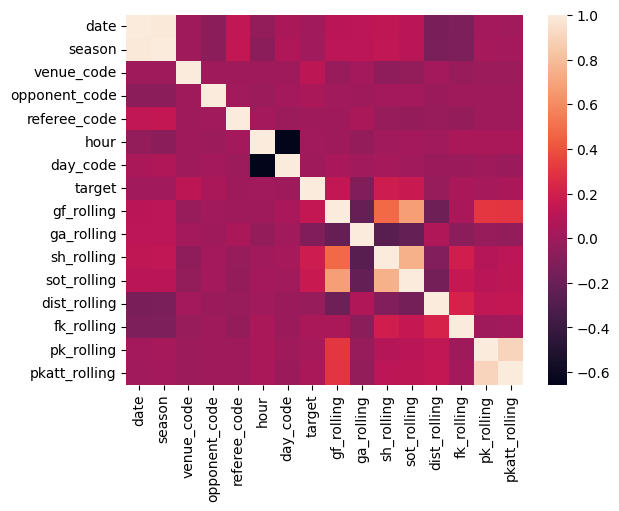

In [74]:
sns.heatmap(matches_rolling.drop(columns="team").corr())

### Przygotowanie cech, na podstawie których będę przewidywał wynik meczu (target)

In [75]:
X = matches[[
    "venue_code",
    "opponent_code",
    "referee_code",
    "sh",
    "sot",
    "dist",
    "fk",
    "pk",
    "pkatt"
]]
Y = matches["target"]

In [76]:
X_other = matches_rolling[[
    "venue_code",
    "opponent_code",
    "referee_code",
    "ga_rolling",
    "gf_rolling",
    "sh_rolling",
    "sot_rolling",
    "dist_rolling",
    "fk_rolling",
    "pk_rolling",
    "pkatt_rolling"
]]
Y_other = matches_rolling["target"]

In [77]:
nan_columns = X.isna().sum()
print("Liczba NaN w każdej kolumnie:\n", nan_columns)

Liczba NaN w każdej kolumnie:
 venue_code       0
opponent_code    0
referee_code     0
sh               0
sot              0
dist             1
fk               0
pk               0
pkatt            0
dtype: int64


### Odrzucenie wierszu z wartością NaN w kolumnie dist

In [78]:
X_cleaned = X.dropna(axis=1)

<Axes: >

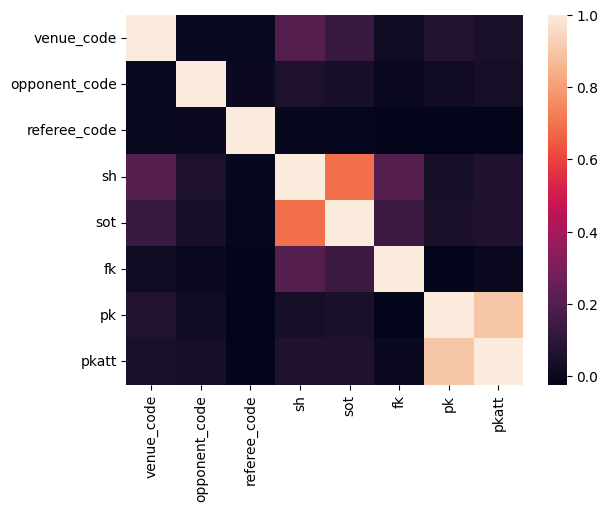

In [79]:
sns.heatmap(X_cleaned.corr())

In [80]:
nan_columns = X_other.isna().sum()
print("Liczba NaN w każdej kolumnie:\n", nan_columns)

Liczba NaN w każdej kolumnie:
 venue_code       0
opponent_code    0
referee_code     0
ga_rolling       0
gf_rolling       0
sh_rolling       0
sot_rolling      0
dist_rolling     0
fk_rolling       0
pk_rolling       0
pkatt_rolling    0
dtype: int64


In [81]:
X_cleaned

,venue_code,opponent_code,referee_code,sh,sot,fk,pk,pkatt
1,0,5,4,17.0,8.0,0.0,0,0
3,1,16,25,14.0,4.0,0.0,0,0
4,0,19,9,29.0,9.0,2.0,0,1
5,1,9,18,6.0,4.0,0.0,1,1
6,0,24,1,29.0,13.0,1.0,0,0
...,...,...,...,...,...,...,...,...
38,0,22,2,12.0,3.0,1.0,0,0
39,1,24,13,11.0,2.0,1.0,0,0
40,0,6,11,2.0,0.0,0.0,0,0
41,1,5,13,6.0,2.0,0.0,0,0


## Kod dotyczący modeli i wyników przewidywań

### SVC

In [82]:
def creating_svc_model(X,Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    sc = StandardScaler()
    X_train_sc = sc.fit_transform(X_train)
    X_test_sc = sc.transform(X_test)
    
    clf = SVC(kernel='rbf')
    clf.fit(X_train_sc, Y_train)
    Y_pred = clf.predict(X_test_sc)
    return Y_pred, Y_test, clf

### RFC z wykorzystaniem GridSearchCV

In [83]:
from sklearn.model_selection import GridSearchCV
def creating_rf_model(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    sc = StandardScaler()
    X_train_sc = sc.fit_transform(X_train)
    X_test_sc = sc.transform(X_test)
    param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
    }   

    rf_model = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='recall')
    grid_result = grid_search.fit(X_train_sc, Y_train)
    Y_pred = grid_result.best_estimator_.predict(X_test_sc)
    
    return Y_pred, Y_test, rf_model

### Wyświetlanie wyników klasyfikacji przy pomocy raportu dotyczącego klasyfikacji i macierzy pomyłek

In [84]:
def draw_plot_result_clf(Y_test, Y_pred):
    print("Classification Report:")
    print(classification_report(Y_test, Y_pred))
    conf_matrix = confusion_matrix(Y_test, Y_pred)

    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d')
    plt.xlabel('Przewidywany wynik')
    plt.ylabel('Rzeczywisty wynik')
    plt.title('Macierz pomyłek')
    plt.show()

### Wyświetlenie krzywej ROC

In [85]:
def auc_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

## Eksperymenty dla ramki matches

In [86]:
Y_test_svc, Y_pred_svc, clf = creating_svc_model(X_cleaned, Y)

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.73      0.79       550
           1       0.49      0.68      0.57       210

    accuracy                           0.72       760
   macro avg       0.67      0.71      0.68       760
weighted avg       0.76      0.72      0.73       760



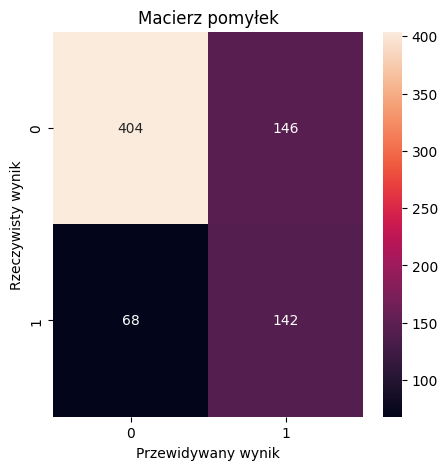

In [87]:
draw_plot_result_clf(Y_test_svc, Y_pred_svc)

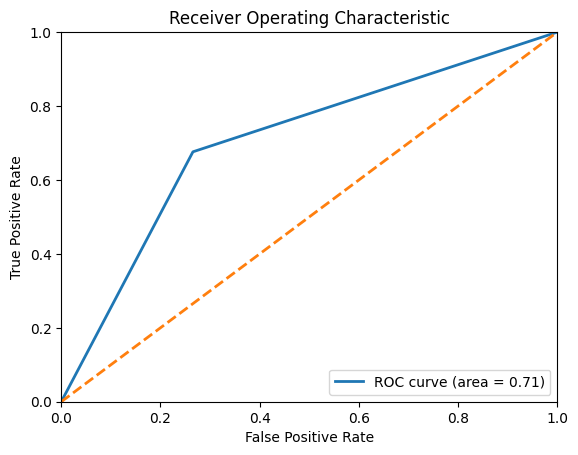

0.7053679653679654

In [88]:
auc_roc(Y_test_svc, Y_pred_svc)

In [89]:
Y_test_rf, Y_pred_rf, rf = creating_rf_model(X_cleaned, Y)

c:\Users\oleks\OneDrive\Pulpit\coding\msid-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\oleks\OneDrive\Pulpit\coding\msid-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\oleks\OneDrive\Pulpit\coding\msid-project\.venv\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\oleks\OneDrive\Pulpit\coding\msid-project\.venv\Lib\site-packages\skl

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       508
           1       0.53      0.61      0.57       252

    accuracy                           0.69       760
   macro avg       0.66      0.67      0.66       760
weighted avg       0.70      0.69      0.70       760



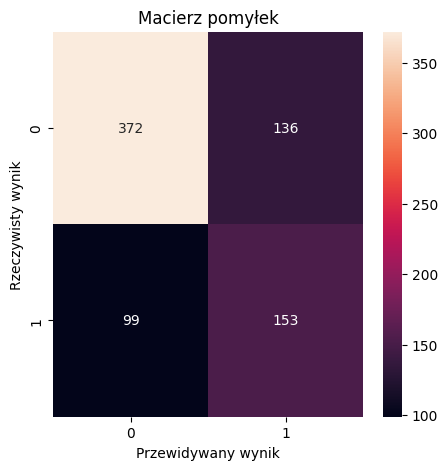

In [90]:
draw_plot_result_clf(Y_test_rf, Y_pred_rf)

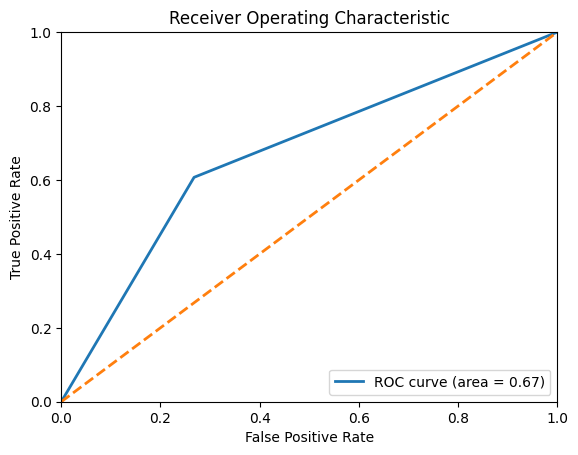

0.6697131608548932

In [91]:
auc_roc(Y_test_rf, Y_pred_rf)

## Eksperymenty dla matches_rolling

In [92]:
Y_test_other_svc, Y_pred_other_svc, clf_other = creating_svc_model(X_other, Y_other)

In [93]:
Y_test_other_rf, Y_pred_other_rf, rf_other = creating_rf_model(X_other, Y_other)

c:\Users\oleks\OneDrive\Pulpit\coding\msid-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\oleks\OneDrive\Pulpit\coding\msid-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\oleks\OneDrive\Pulpit\coding\msid-project\.venv\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\oleks\OneDrive\Pulpit\coding\msid-project\.venv\Lib\site-packages\skl

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.63      0.75       653
           1       0.19      0.60      0.29        91

    accuracy                           0.63       744
   macro avg       0.55      0.62      0.52       744
weighted avg       0.83      0.63      0.69       744



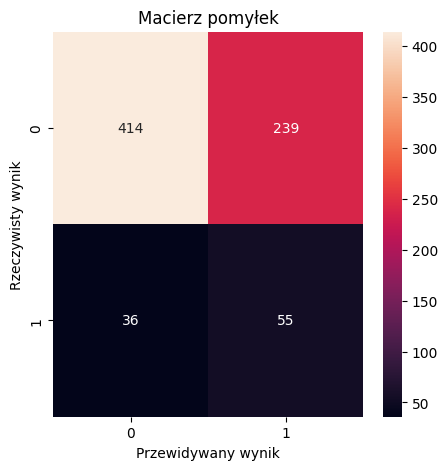

In [94]:
draw_plot_result_clf(Y_test_other_svc, Y_pred_other_svc)

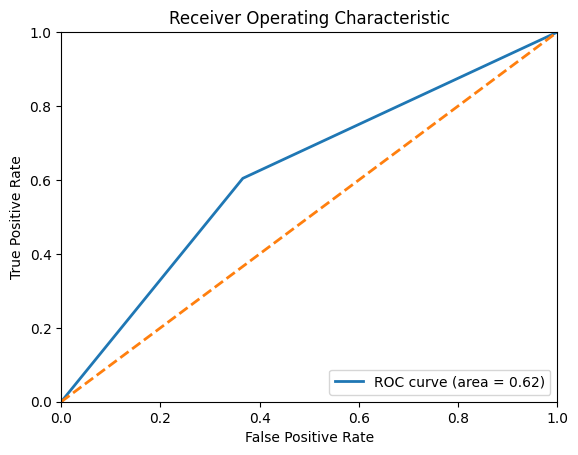

0.6191962708042341

In [95]:
auc_roc(Y_test_other_svc, Y_pred_other_svc)

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.65      0.73       576
           1       0.32      0.56      0.40       168

    accuracy                           0.63       744
   macro avg       0.58      0.60      0.57       744
weighted avg       0.72      0.63      0.66       744



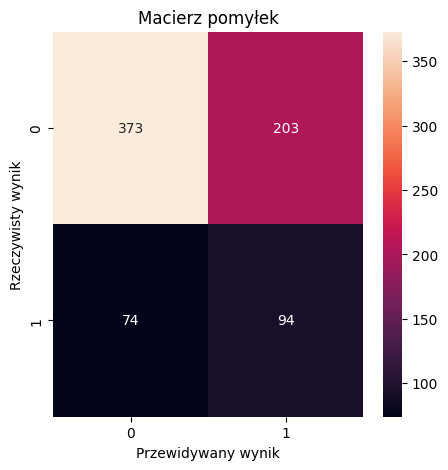

In [96]:
draw_plot_result_clf(Y_test_other_rf, Y_pred_other_rf)

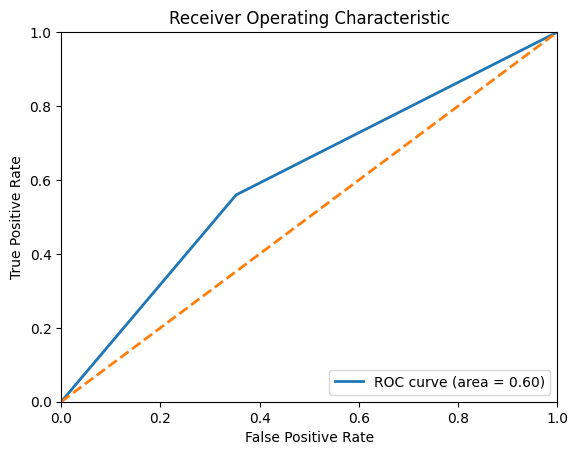

0.603546626984127

In [97]:
auc_roc(Y_test_other_rf, Y_pred_other_rf)

## Eksperymenty dla matches_rolling bez kolumn _rolling

In [98]:
X_norolling = matches_rolling[[
    "venue_code",
    "opponent_code",
    "referee_code",
    "day_code"
]]

In [99]:
Y_test_norolling_svc, Y_pred_norolling_svc, clf_norolling = creating_svc_model(X_norolling, Y_other)

In [100]:
Y_test_norolling_rf, Y_pred_norolling_rf, rf_norolling = creating_rf_model(X_norolling, Y_other)

c:\Users\oleks\OneDrive\Pulpit\coding\msid-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\oleks\OneDrive\Pulpit\coding\msid-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\oleks\OneDrive\Pulpit\coding\msid-project\.venv\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\oleks\OneDrive\Pulpit\coding\msid-project\.venv\Lib\site-packages\skl

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.62      0.76       722
           1       0.03      0.36      0.05        22

    accuracy                           0.62       744
   macro avg       0.50      0.49      0.41       744
weighted avg       0.94      0.62      0.74       744



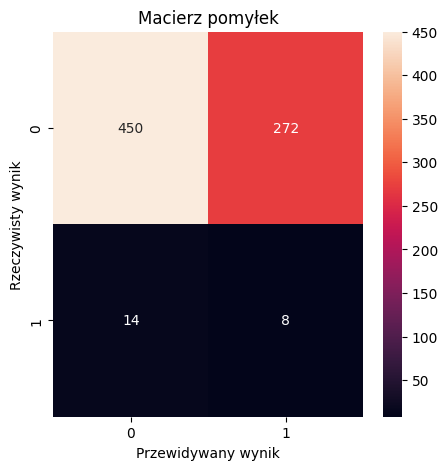

In [101]:
draw_plot_result_clf(Y_test_norolling_svc, Y_pred_norolling_svc)

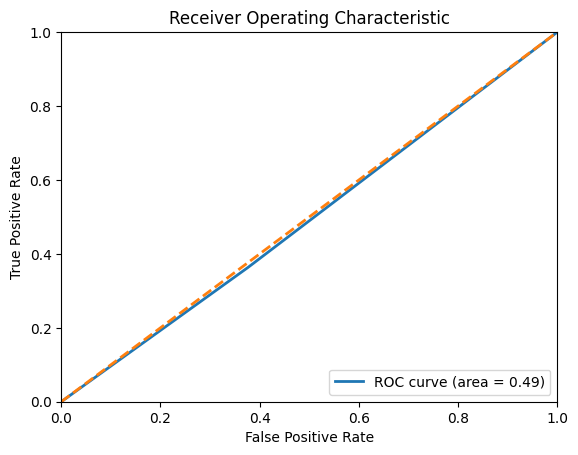

0.4934525308486528

In [102]:
auc_roc(Y_test_norolling_svc, Y_pred_norolling_svc)

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.66      0.68       505
           1       0.38      0.44      0.40       239

    accuracy                           0.59       744
   macro avg       0.54      0.55      0.54       744
weighted avg       0.60      0.59      0.59       744



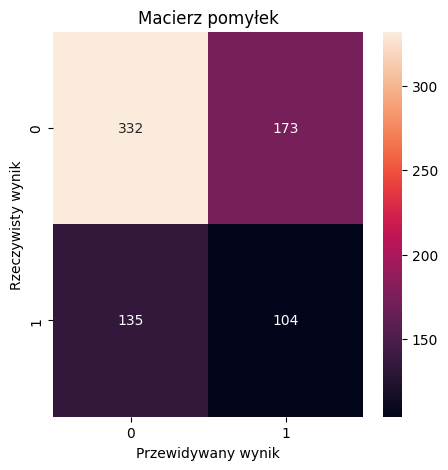

In [103]:
draw_plot_result_clf(Y_test_norolling_rf, Y_pred_norolling_rf)

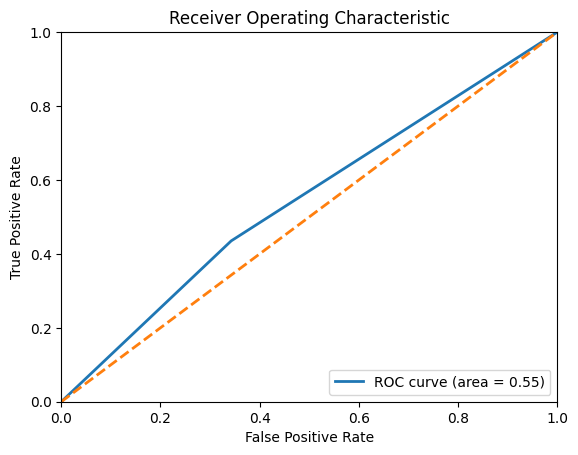

0.5462860930444509

In [104]:
auc_roc(Y_test_norolling_rf, Y_pred_norolling_rf)